In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
%config InlineBackend.figure_format='retina'

In [2]:
# assume that critical BS has sharpe ratio 1
# we will express BS as a fraction of the critical BS

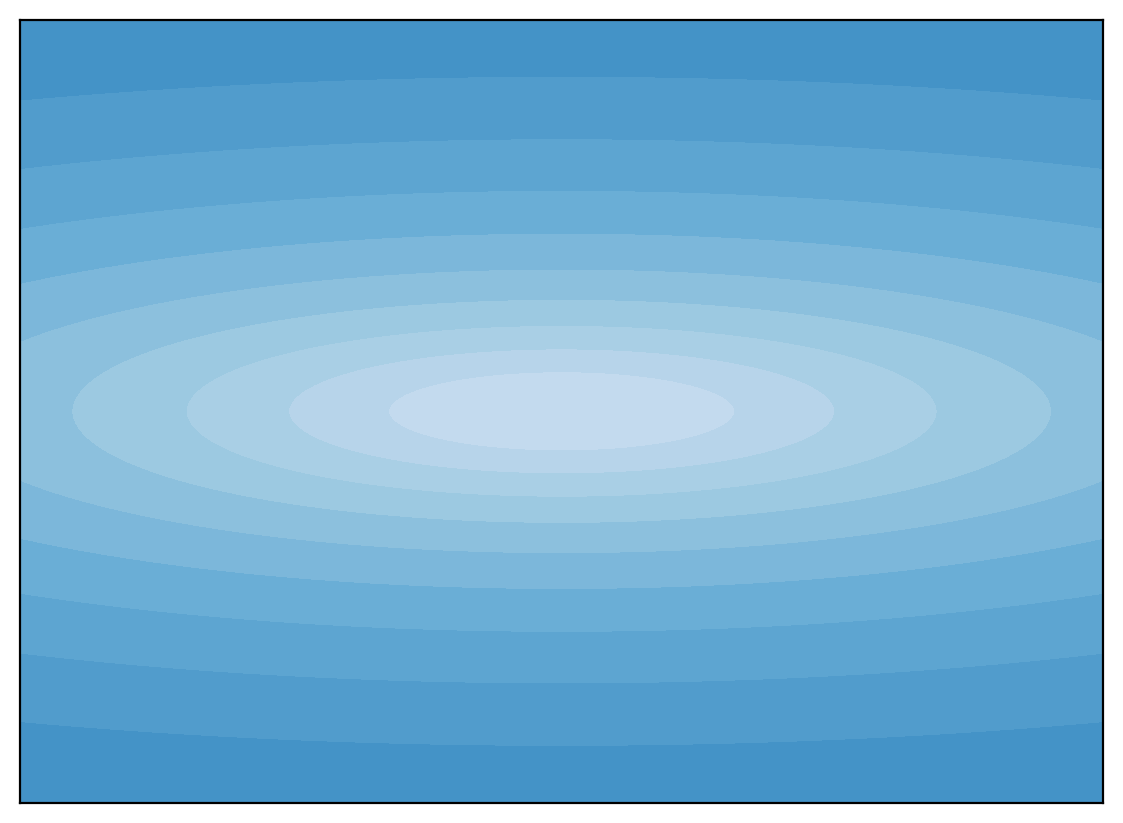

In [3]:
# define loss landscape
n_dim = 2
def loss_fn(xy):
    x = xy[..., 0]
    y = xy[..., 1]
    return x**2 + 10*y**2

# helper to plot landscape
def plot_landscape(ax):
    x = jnp.linspace(-1.2, 1.2, 400)
    y = jnp.linspace(-1.2, 1.2, 400)
    xy = jnp.stack(jnp.meshgrid(x, y), -1)
    z = loss_fn(xy)
    z = jnp.log(z+0.3) # scaling for nicer contour plot
    z -= z.min()
    z /= z.max()
    z += 0.1
    ax.contourf(x, y, z, cmap='Blues', vmin=-0.5, vmax=2., levels=10)

    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(layout='constrained', figsize=(5.5, 4))
plot_landscape(ax)
plt.show()

In [4]:
# define optimizer
def opt(key, x0, lr, beta=0., bs=None, n_steps=10, return_chain=False):

    # initialize momentum
    m = jnp.zeros(n_dim)

    # compute noise
    # if BS=1 (i.e. critical) then noise_scale=1, i.e. sharpe ratio 1
    # noise scale scales with sqrt(BS)
    noise = jax.random.normal(key, [n_steps, n_dim])
    noise_scale = 0 if bs is None else 1/jnp.sqrt(bs)

    # run optimizer
    def opt_step(carry, step_noise):
        x, m = carry
        grad = jax.grad(loss_fn)(x) # compute true gradient
        grad += noise_scale * jnp.abs(grad) * step_noise # simulate mini-batch gradient noise
        m = beta * m + (1-beta) * grad # update momentum
        x -= lr * m # update position
        return (x, m), x # (carry), (output)
    _, chain = jax.lax.scan(opt_step, (x0, m), xs=noise)

    # if returning chain, prepend initial position;
    # otherwise return last position only
    if return_chain: return jnp.r_[x0[None], chain]
    else: return chain[-1]

# sample multiple trajectories
def sample_trajectories(key, x0=None, n_runs=10, *args, **kwargs):

    def sample_trajectory(key):
        key_x0, key_noise = jax.random.split(key)
        x0_local = x0 if x0 is not None else jax.random.normal(key_x0, [n_dim])
        chain = opt(key, x0_local, *args, **kwargs)
        return chain

    # map over keys
    keys = jax.random.split(key, n_runs)
    trajectories = jax.lax.map(sample_trajectory, keys)

    return trajectories

# get average loss across multiple trajectories
def get_avg_loss(*args, **kwargs):
    trajectories = sample_trajectories(*args, **kwargs, return_chain=False) # [n_traj, xy]
    return jnp.median(loss_fn(trajectories))

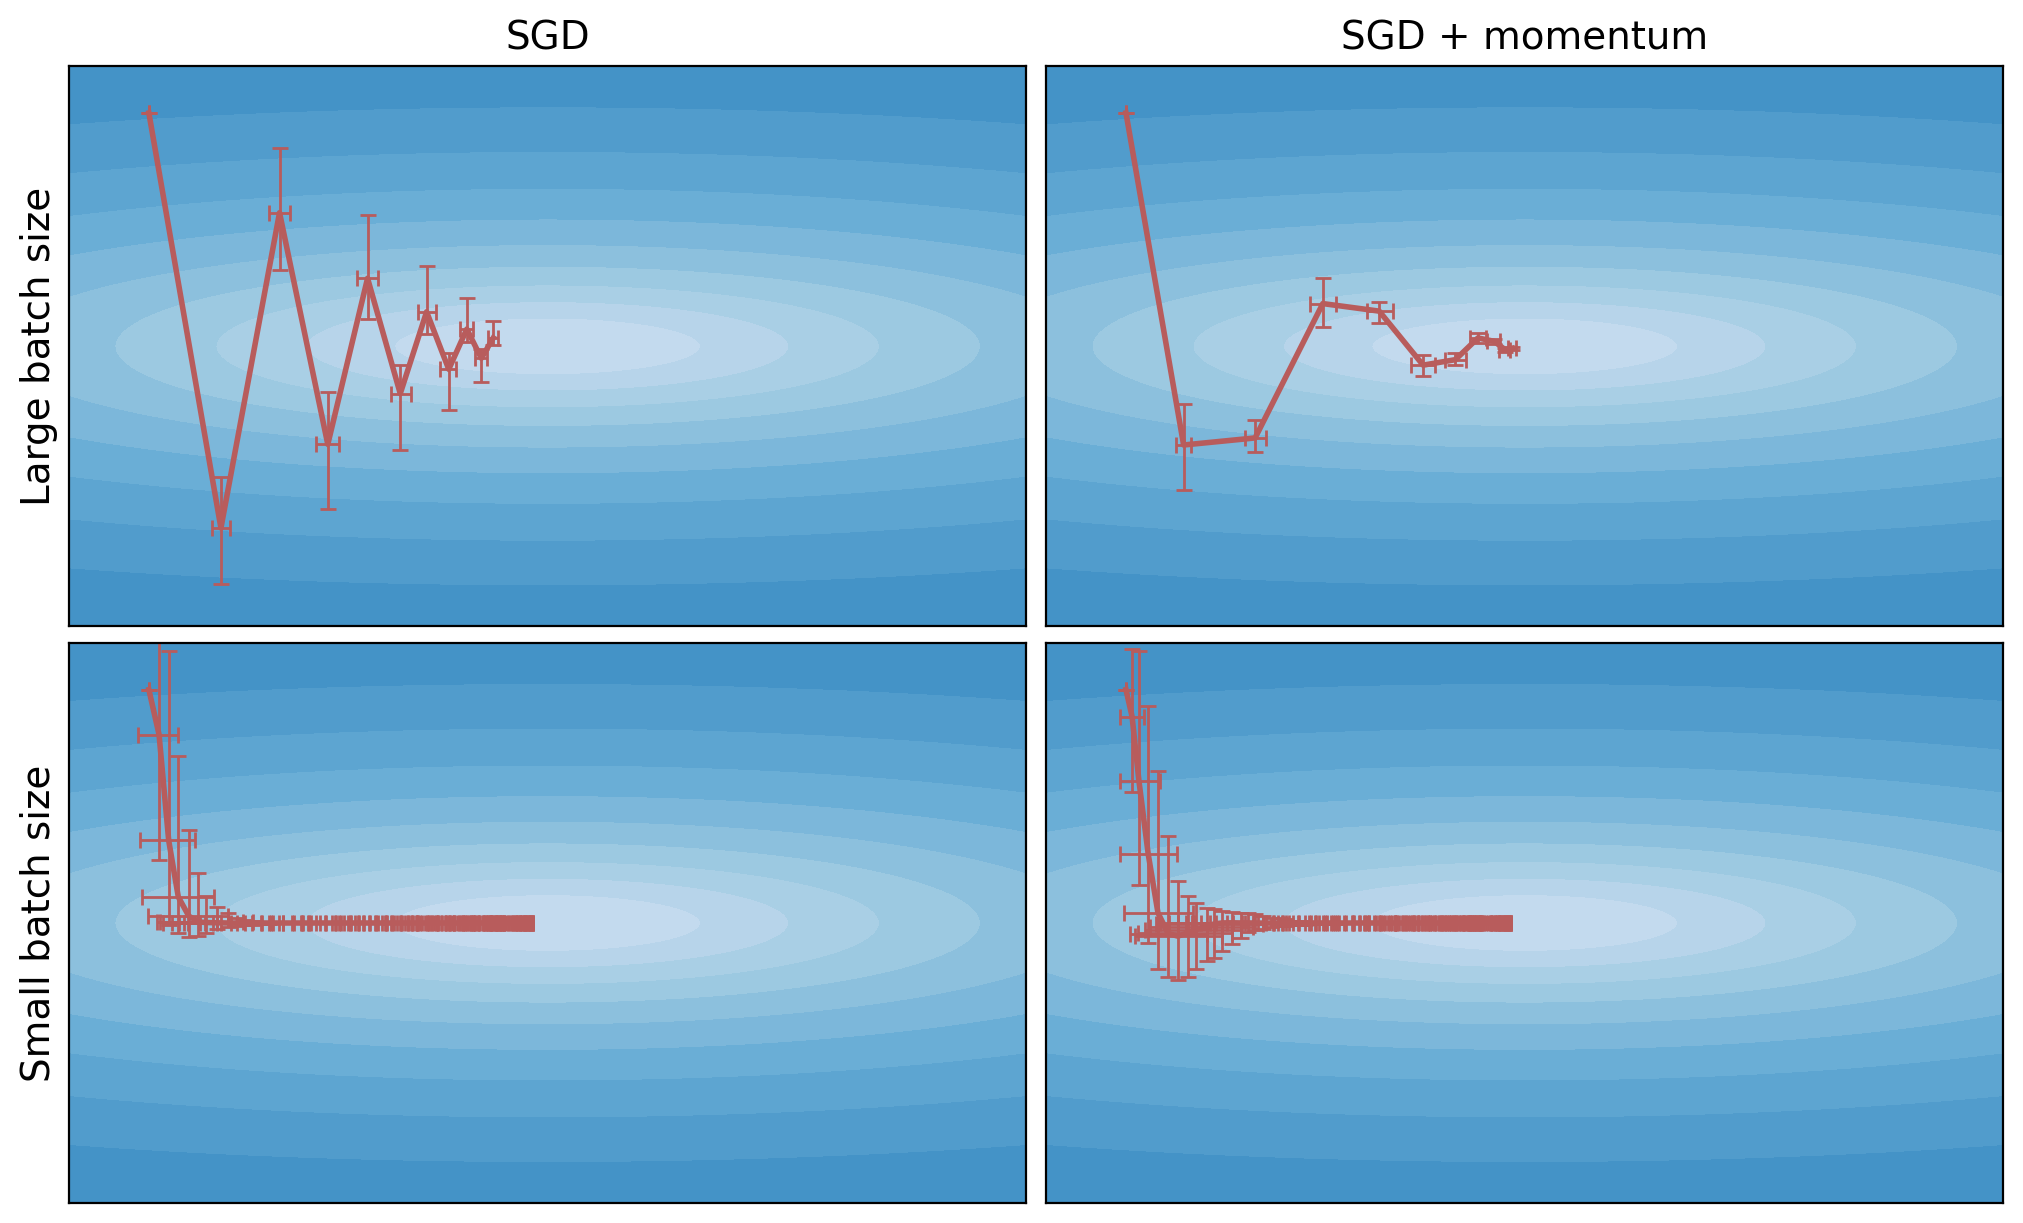

In [5]:
# set hparams to plot
# to_plot = (
#     dict(bs=20, n_steps=10, lr=0.09, beta=0.),
#     dict(bs=20, n_steps=10, lr=0.12, beta=0.4),
#     dict(bs=0.1, n_steps=100, lr=0.01, beta=0.),
#     dict(bs=0.1, n_steps=100, lr=0.01, beta=0.4),
# )
to_plot = (
    dict(bs=5**2, n_steps=10, lr=0.09, beta=0.),
    dict(bs=5**2, n_steps=10, lr=0.12, beta=0.4),
    dict(bs=0.3**2, n_steps=100, lr=0.012, beta=0.),
    dict(bs=0.3**2, n_steps=100, lr=0.012, beta=0.4),
)

x0 = jnp.array([-1., 1.])
key = jax.random.PRNGKey(0)
quantiles = jnp.array([0.25, 0.75])
fig, axs = plt.subplots(2, 2, layout='constrained', figsize=(10, 6))
for i, kwargs in enumerate(to_plot):
    ax = axs.flatten()[i]
    plot_landscape(ax)
    trajectories = sample_trajectories(key, x0, **kwargs, n_runs=1000, return_chain=True)
    x, y = jnp.median(trajectories, axis=0).T # average over random seeds
    xmin, xmax = jnp.quantile(trajectories[..., 0], quantiles, axis=0)
    ymin, ymax = jnp.quantile(trajectories[..., 1], quantiles, axis=0)
    xerr = jnp.stack([x-xmin, xmax-x], 0)
    yerr = jnp.stack([y-ymin, ymax-y], 0)
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, ls='-', color='#B85C5C', capsize=3, lw=2, elinewidth=1)

axs[0, 0].set_ylabel('Large batch size', fontsize=14)
axs[1, 0].set_ylabel('Small batch size', fontsize=14)
axs[0, 0].set_title('SGD', fontsize=14)
axs[0, 1].set_title('SGD + momentum', fontsize=14)
# plt.savefig(f'toy.pdf', dpi=200)
plt.show()